In [1]:
import scanpy as sc
import anndata as ad
import scipy
from scipy.sparse import issparse, csr_matrix
import gseapy as gp
import decoupler as dc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from typing import Optional, Tuple, Dict, Any
import warnings
import gc
import re
import psutil
import logging
import os

# configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# [Data loading] Prepare adata for pre-proc

In [ ]:
# load male and female adata and aggregate
adata_corrected_female = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_female_2025.h5ad')
adata_corrected_male = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_male_2025.h5ad')

In [ ]:
adata_corrected_male

In [ ]:
adata_corrected_female

In [ ]:
same_set = set(adata_corrected_female.var_names) == set(adata_corrected_male.var_names)
print("Same gene set?", same_set)
print("A genes:", adata_corrected_female.n_vars, "B genes:", adata_corrected_male.n_vars)

#### Concat the two pools and name their batches

In [ ]:
for adx in (adata_corrected_female, adata_corrected_male):
    adx.var_names = adx.var_names.astype(str)
    adx.var_names_make_unique()

In [ ]:
adata_cellbender_combined = ad.concat(
    {"male": adata_corrected_male, "female": adata_corrected_female},
    axis=0,
    join="inner",         # use "outer" if you want union of genes (missing filled with 0)
    label="batch",
    index_unique=None     # keep original cell barcodes (ensure they won't collide)
)

In [ ]:
adata_cellbender_combined

In [ ]:
adata_cellbender_combined.obs['batch'].value_counts()

In [ ]:
def remove_duplicates(adata, axis='obs', strategy='first'):
    """
    Remove barcode duplicates with different strategies
    
    Parameters:
    - axis: 'obs' for cells, 'var' for genes
    - strategy: 'first', 'last', 'highest_counts' (for obs only)
    """
    if axis == 'obs':
        index = adata.obs.index
        if strategy == 'first':
            keep_mask = ~index.duplicated(keep='first')
        elif strategy == 'last':
            keep_mask = ~index.duplicated(keep='last')
        elif strategy == 'highest_counts':
            # Keep the cell with highest UMI counts among duplicates
            keep_indices = []
            for name in index.unique():
                name_mask = index == name
                if name_mask.sum() > 1:  # If duplicated
                    if 'nCount_RNA' in adata.obs.columns:
                        best_idx = adata.obs.loc[name_mask, 'nCount_RNA'].idxmax()
                        keep_indices.extend([i for i, idx in enumerate(adata.obs.index) if idx == best_idx])
                    else:
                        # Fall back to first if no count info
                        keep_indices.append(np.where(name_mask)[0][0])
                else:
                    keep_indices.extend(np.where(name_mask)[0])
            keep_mask = np.zeros(adata.n_obs, dtype=bool)
            keep_mask[keep_indices] = True
        
        return adata[keep_mask].copy()
    
    else:  # axis == 'var'
        index = adata.var.index
        if strategy == 'first':
            keep_mask = ~index.duplicated(keep='first')
        elif strategy == 'last':
            keep_mask = ~index.duplicated(keep='last')
        else:
            keep_mask = ~index.duplicated(keep='first')  # Default to first
        
        return adata[:, keep_mask].copy()

In [ ]:
print("\n=== Removing Duplicates ===")
original_shape = adata_cellbender_combined.shape
# Remove cell duplicates (keeping first occurrence)
adata_subset = remove_duplicates(adata_cellbender_combined, axis='obs', strategy='first')

In [ ]:
dup_mask = adata_subset.obs.index.duplicated(keep=False)

# Extract duplicated barcodes and their counts
duplicates = adata_subset.obs.index[dup_mask]
duplicate_cells = duplicates.value_counts()

print("Number of duplicated barcodes in corrected data:", len(duplicate_cells))
print(duplicate_cells)
#find if common genes is unique in index object
unique_genes_corrected = adata_subset.var.index.unique()
print(f"Unique genes in corrected data: {len(unique_genes_corrected)}")

In [ ]:
adata_subset

In [ ]:
# save the combined adata
adata_subset.write_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_aggr_2025_dedup.h5ad')

### Combine the cellbender layer

In [ ]:
# load datasets
adata_corrected = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_aggr_2025_dedup.h5ad')
adata_uncorrected = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/ERCC1_KO_mice_aggr_updated.h5ad')

In [ ]:
adata_uncorrected.obs

In [ ]:
# Use regex to replace any suffix _2 through _8 with _1
adata_uncorrected.obs.index = adata_uncorrected.obs.index.str.replace(r'-[2-8]$', '-1', regex=True)

In [ ]:
# check of cell ranger uncorrected data has duplicates
dup_mask = adata_uncorrected.obs.index.duplicated(keep=False)

# Extract duplicated barcodes and their counts
duplicates = adata_uncorrected.obs.index[dup_mask]
duplicate_cells = duplicates.value_counts()

print("Number of duplicated barcodes in corrected data:", len(duplicate_cells))
print(duplicate_cells)
#find if common genes is unique in index object
unique_genes_corrected = adata_uncorrected.var.index.unique()
print(f"Unique genes in corrected data: {len(unique_genes_corrected)}")

In [ ]:
print("\n=== Removing Duplicates ===")
original_shape = adata_uncorrected.shape
# Remove cell duplicates (keeping first occurrence)
adata_uncorrected = remove_duplicates(adata_uncorrected, axis='obs', strategy='first')

In [ ]:
# check of cell ranger uncorrected data has duplicates
dup_mask = adata_uncorrected.obs.index.duplicated(keep=False)

# Extract duplicated barcodes and their counts
duplicates = adata_uncorrected.obs.index[dup_mask]
duplicate_cells = duplicates.value_counts()

print("Number of duplicated barcodes in corrected data:", len(duplicate_cells))
print(duplicate_cells)
#find if common genes is unique in index object
unique_genes_corrected = adata_uncorrected.var.index.unique()
print(f"Unique genes in corrected data: {len(unique_genes_corrected)}")

In [ ]:
# find overlapping cells
common_cells = adata_uncorrected.obs.index.intersection(adata_corrected.obs.index)
common_genes = adata_uncorrected.var.index.intersection(adata_corrected.var.index)
print(f"Found {len(common_cells)} common cells")
print(f"Found {len(common_genes)} common genes")

In [ ]:
adata_orig_subset = adata_uncorrected[common_cells, common_genes].copy()
adata_corrected_subset = adata_corrected[common_cells, common_genes].copy()

In [ ]:
# copy over all processed data
adata_combined = adata_orig_subset.copy()

In [ ]:
# add cellbender counts as layer
adata_combined.layers['cellbender'] = adata_corrected_subset.X.copy()

In [ ]:
print("Transferring cell metadata (obs)...")
for col in adata_corrected_subset.obs.columns:
    if col not in adata_combined.obs.columns:
        # Initialize new column with appropriate dtype
        if adata_corrected_subset.obs[col].dtype == 'object':
            adata_combined.obs[col] = pd.NA
        else:
            adata_combined.obs[col] = np.nan
    
    # Update values for common cells
    adata_combined.obs[col] = adata_corrected_subset.obs[col]

In [ ]:
adata_combined.obs

In [ ]:
# Transfer obsm with logging
print(f"Transferring {len(adata_corrected_subset.obsm.keys())} obsm entries:")
for key in adata_corrected_subset.obsm.keys():
    print(f"  - {key}: {adata_corrected_subset.obsm[key].shape}")
    adata_combined.obsm[key] = adata_corrected_subset.obsm[key].copy()

# Transfer varm with logging
print(f"Transferring {len(adata_corrected_subset.varm.keys())} varm entries:")
for key in adata_corrected_subset.varm.keys():
    print(f"  - {key}: {adata_corrected_subset.varm[key].shape}")
    adata_combined.varm[key] = adata_corrected_subset.varm[key].copy()

# Transfer uns with logging
print(f"Transferring {len(adata_corrected_subset.uns.keys())} uns entries:")
for key in adata_corrected_subset.uns.keys():
    print(f"  - {key}")
    adata_combined.uns[key] = adata_corrected_subset.uns[key]

In [ ]:
adata_combined

# [Pre-proc] Normalization, feature selection, dim reduction

In [2]:
infile = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/query_combined.h5ad'

In [3]:
adata = sc.read_h5ad(infile)

In [4]:
adata

AnnData object with n_obs × n_vars = 60965 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_cb', 'hb_cb'
    uns: 'log1p', 's

In [5]:
adata.X = adata.layers['cellbender']

In [6]:
adata.obs['total_counts_cb'] = adata.X.sum(axis=1).A1

In [7]:
# add the vars you need to get per-gene metrics on (for corrected counts add new var columns)
adata.var['mt_cb'] = adata.var_names.str.startswith('mt-')
adata.var['ribo_cb'] = adata.var_names.str.startswith(('rps', 'rpl'))
adata.var["hb_cb"] = adata.var_names.str.contains("^hb[^(p)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt_cb", "ribo_cb", "hb_cb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 60965 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'total_counts_cb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_cb', 'hb_cb'
 

In [8]:
# cut off cells to compare cellbender vs uncorrected counts on the same scale
adata = adata[adata.obs['total_counts_mt_cb'] < 300]
adata = adata[adata.obs['total_counts_mt'] < 300]

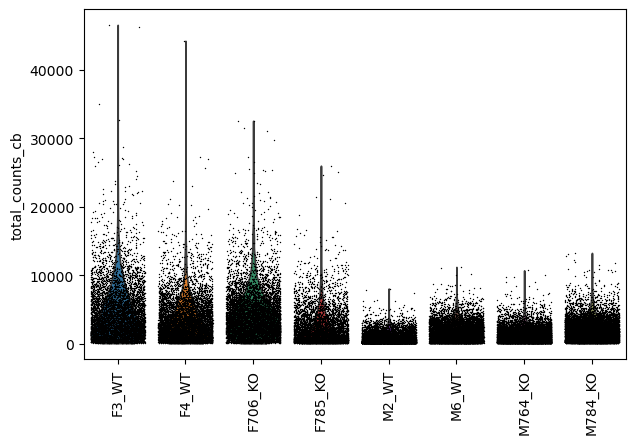

In [9]:
sc.pl.violin(
    adata,
    ["total_counts_cb"],
    groupby='sample_id',
    jitter=0.4,
    multi_panel=True,
    rotation=90
)

#### Filter cells based on cell bender probability

In [16]:
# cell bender probability of being cell and not soup
adata = adata[adata.obs['cell_probability'] > 0.9]
# remove the barcodes that are predicted to be doublets
adata = adata[adata.obs['predicted_doublet'] == False]
# Basic filtering based on number of genes
sc.pp.filter_cells(adata, min_genes=200) 

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


In [17]:
# get the number of F and M cells from sex obs
adata.obs['sex'].value_counts()

sex
M    26564
F    23918
Name: count, dtype: int64

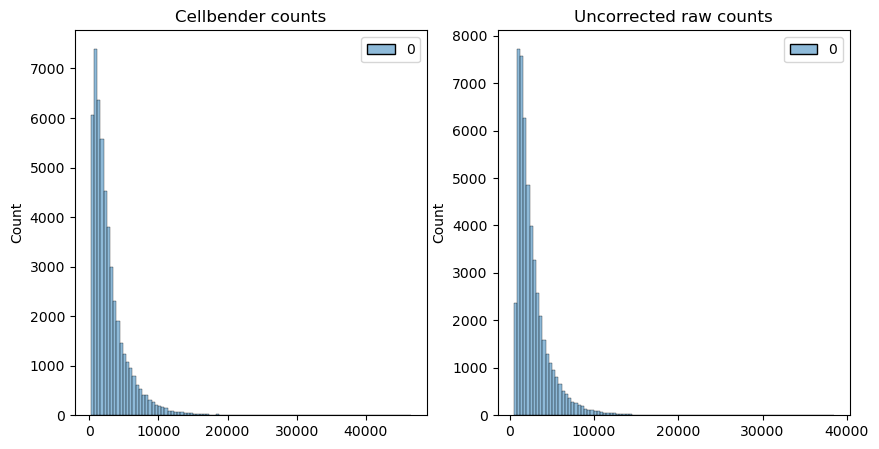

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.layers["cellbender"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Cellbender counts")
p2 = sns.histplot(adata.layers["counts"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Uncorrected raw counts")
plt.show()

## Log Normalization

In [19]:
adata.X = adata.layers['cellbender'].copy()
#adata.X = adata.layers['counts'].copy()
# normalize counts
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm_cb"] = sc.pp.log1p(scales_counts["X"], copy=True)
#adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [20]:
adata

AnnData object with n_obs × n_vars = 50482 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'total_counts_cb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_cb', 'hb_cb'
 

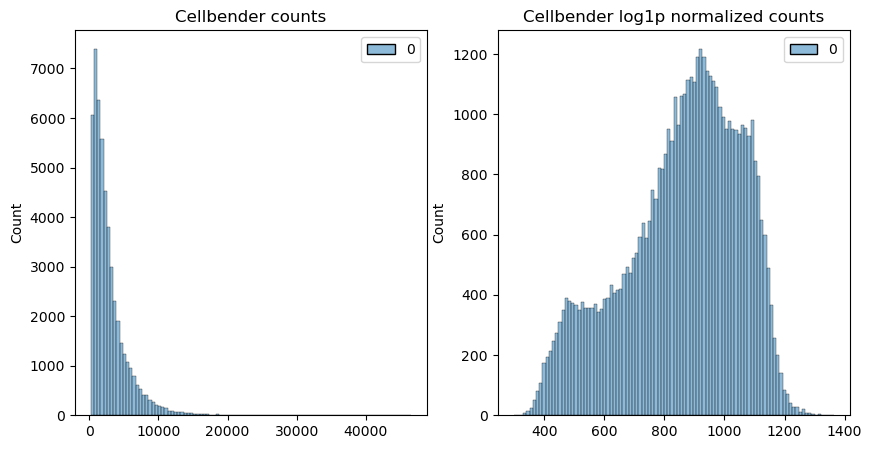

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.layers["cellbender"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Cellbender counts")
p2 = sns.histplot(adata.layers["log1p_norm_cb"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Cellbender log1p normalized counts")
# p1 = sns.histplot(adata.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
# axes[0].set_title("Counts")
# p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
# axes[1].set_title("Log1p normalized counts")
plt.show()

#### Check for mislabeling of gender samples and key pathways

In [58]:
# check if these genes are present in the data 
list_male_genes = [ 'Eif2s3y', 'Ddx3y', 'Kdm5d', 'Uty', 'Zfy1', 'Zfy2', 'Sry', 'Rbmy1a1', 'Ssty1', 
    'Ssty2', 'Tspy-ps1', 'Prss21', 'Mid1', 'Ube1y', 'Smcy', 'Usp9y', 'Zfy-ps1'
    ]

# Find available Y genes
available_male_genes = [gene for gene in list_male_genes if gene in adata.var_names]
print(f"\nFound {len(available_male_genes)} Y chromosome genes in dataset:")
for gene in available_male_genes:
    print(f"{gene}")



Found 12 Y chromosome genes in dataset:
Eif2s3y
Ddx3y
Kdm5d
Uty
Zfy1
Zfy2
Sry
Ssty1
Ssty2
Prss21
Mid1
Usp9y


In [59]:
### DDR genes 
dna_damage_response = ['Atr', 'Atm', 'Chek1', 'Chek2', 'Trp53', 'Mdm2', 'Cdkn1a', 'Brca1', 'Brca2', 'Rad51', 'Xrcc6', 'Prkdc', 'Parp1', 'Xrcc1', 'Fancd2']

# Find available DDR genes
available_ddr_genes = [gene for gene in dna_damage_response if gene in adata.var_names]
print(f"\nFound {len(available_ddr_genes)} DNA damage response genes in dataset:")
for gene in available_ddr_genes:
    print(f"{gene}")


Found 15 DNA damage response genes in dataset:
Atr
Atm
Chek1
Chek2
Trp53
Mdm2
Cdkn1a
Brca1
Brca2
Rad51
Xrcc6
Prkdc
Parp1
Xrcc1
Fancd2


In [60]:
adata.X = adata.layers['log1p_norm_cb']

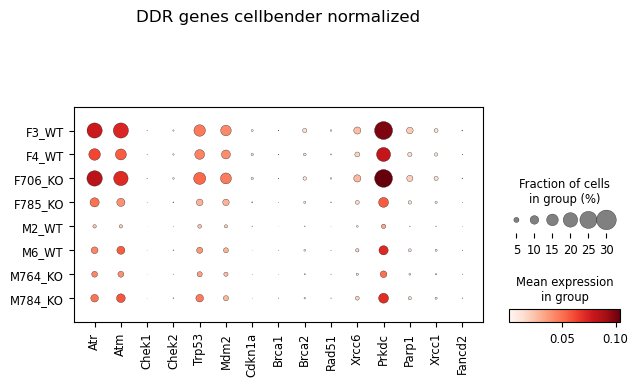

In [63]:
# plot gene expression dotplot of these genes
# sc.pl.dotplot(adata, available_male_genes, groupby='sample_id', title="Y chromosome genes cellbender normalized")
sc.pl.dotplot(adata, available_ddr_genes, groupby='sample_id', title="DDR genes cellbender normalized")
plt.show()

In [73]:
from scipy import stats
adata_female = adata[adata.obs['sex'] == 'F']
adata_male = adata[adata.obs['sex'] == 'M']

In [80]:
from scipy import stats

# Calculate correlation between total counts and DDR gene expression
ddr_genes = ['Atr', 'Chek1', 'Chek2', 'Trp53', 'Mre11', 
             'Cdkn1a', 'Brca1', 'Brca2', 'Rad51', 'Prkdc', 
             'Parp1', 'Xrcc1', 'Fancd2']

In [82]:
housekeeping_genes = ['Actb', 'Gapdh', 'Pgk1', 'Rpl13a', 'Rplp0']

In [83]:
# For each DDR gene
for gene in housekeeping_genes:
    if gene in adata.var_names:
        expr = adata_female[:, gene].X.toarray().flatten()
        total_counts = adata_female.obs['total_counts'].values
        
        corr, pval = stats.spearmanr(total_counts, expr)
        print(f"{gene}: correlation = {corr:.3f}, p-value = {pval:.3e}")

Actb: correlation = 0.379, p-value = 0.000e+00
Gapdh: correlation = 0.409, p-value = 0.000e+00
Pgk1: correlation = 0.331, p-value = 0.000e+00
Rpl13a: correlation = -0.000, p-value = 9.392e-01
Rplp0: correlation = -0.018, p-value = 3.077e-03


In [84]:
# For each DDR gene
for gene in housekeeping_genes:
    if gene in adata.var_names:
        expr = adata_male[:, gene].X.toarray().flatten()
        total_counts = adata_male.obs['total_counts'].values
        
        corr, pval = stats.spearmanr(total_counts, expr)
        print(f"{gene}: correlation = {corr:.3f}, p-value = {pval:.3e}")

Actb: correlation = 0.368, p-value = 0.000e+00
Gapdh: correlation = -0.050, p-value = 1.664e-19
Pgk1: correlation = 0.216, p-value = 0.000e+00
Rpl13a: correlation = -0.035, p-value = 2.547e-10
Rplp0: correlation = -0.040, p-value = 2.833e-13


In [54]:
# write the adata object to a file
adata.write('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/query_norm_v2.h5ad')

## Feature selection

In [ ]:
# Filter out genes with very low expression
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_genes(adata, min_counts=10)

In [ ]:
# set the normalized counts to the active layer
adata.X = adata.layers['log1p_norm_cb']

In [ ]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger',n_top_genes=2000)

In [ ]:
sc.pl.highly_variable_genes(adata)

### Dim reduction

In [ ]:
adata.obs['total_counts_cb'] = np.array(adata.layers['cellbender'].sum(axis=1)).flatten()

In [ ]:
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ["total_counts_cb", "pct_counts_mt_cb"])
sc.pp.scale(adata, max_value=10)

In [ ]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=20, log=True)
sc.pp.neighbors(adata)

In [ ]:
sc.pl.pca_scatter(adata, color="total_counts_cb")

# [Labeling] Clustering, Annotation, Markers

In [ ]:
sc.tl.umap(adata, random_state=42, min_dist=1, spread=1)
sc.tl.leiden(adata, key_added=f"leiden", resolution=0.50)

In [ ]:
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

### Marker genes per cluster

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')  # You can choose other methods like 'wilcoxon', 'logreg'
sc.tl.dendrogram(adata, groupby="leiden")
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", standard_scale="var", n_genes=5)

In [ ]:
marker_genes = [
    "Ano4", "Prkar1a", "Tnxb", "Egfr", "Gsn",
    "Abi3bp", "Ptprd", "Col22a1", "Adamts20", "App", "Trpc3", "Cacna1c",
    "Slc35f1", "Hs6st3", "Chodl", "Pax7", "Flt1", "Mecom",
    "Dach1", "Pecam1", "F13a1", "Mctp1", "Slc9a9", "Sorbs2",
    "Myh1", "Kcnn2", "Acss2", "Fhl1"
]
sc.pl.umap(adata,color=[*marker_genes,"leiden"],legend_loc="on data",frameon=False)